<a href="https://colab.research.google.com/github/catalinapesquet/PyTorch-Notes-and-Codes/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

torch.__version__

'2.5.0+cu121'

In [ ]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

The data we're going to be using is a subset of the Food101 dataset.
Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

In [ ]:
import requests # to request something from github
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder not exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download the data into the folders
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content) # write the content of my request into my file

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: # pass it in the data path, giving read permission instead of write
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path) # extract all the info into image path

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


In [ ]:
image_path # where all the content of the zip file is going to

PosixPath('data/pizza_steak_sushi')

## 2. Become one with the data (data preparation)

In [ ]:
import os
def walk_through_dir(dir_path): # walk through each directory and see what's going on
  """ walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path): # goes into diretory
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak


It looks like we've got about 75 images per training class and 25 images per testing class.

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

1. Get all of the image paths
2. Pick a random image path using Python's random.choic()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Open the image with Python's PIL

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/sushi/840444.jpg
Image class: sushi
Image height: 512
Image width: 512


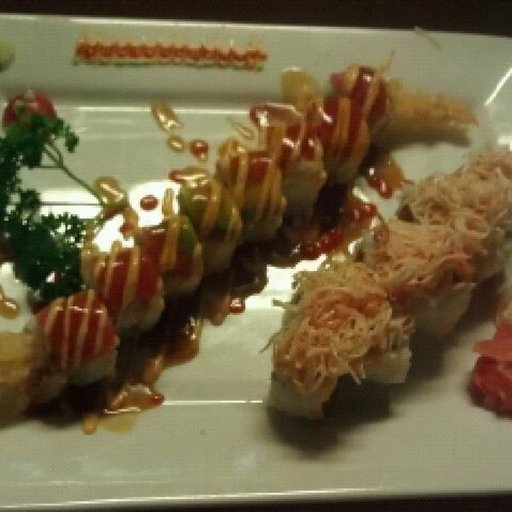

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(2)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) #  glob module finds all the pathnames matching a specified pattern, here */*/jpg

# 2. Get random image path
random_image_path = random.choice(image_path_list) # returns a randomly selected element from the specified sequence (strin, list, range, tuple)

# 3. Get image class from path name
image_class = random_image_path.parent.stem #  class is the name of the directory where the image is stored
# stem returns the final path component, without its suffix

# 4. Open image
img =  Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img



We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.

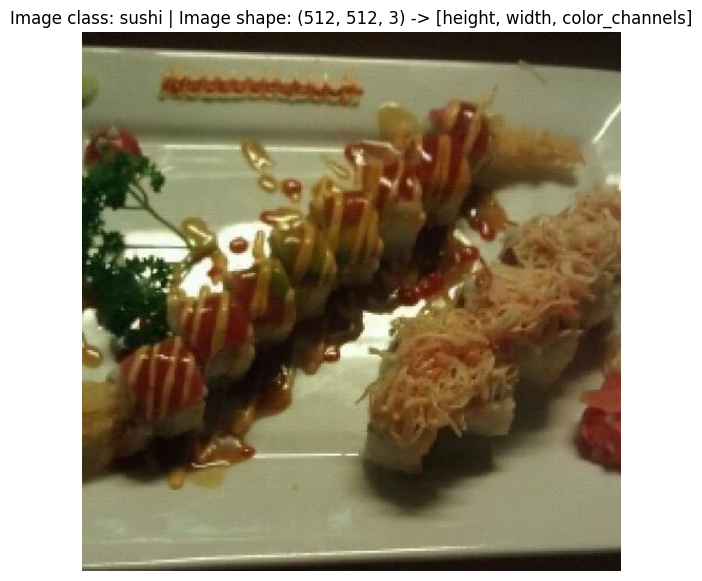

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

Load our image data into PyTorch:
1. Turn into tensors
2. Turn into a toch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader



In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with tochvision.transforms

Using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes.

Get experience with torchvision.transforms, let's write a series of transform steps that:

* Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
* Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
* Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().

https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [ ]:
# Write transform for image
data_transform = transforms.Compose([ # Composes several transforms together
    # Resize the image to 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0

])

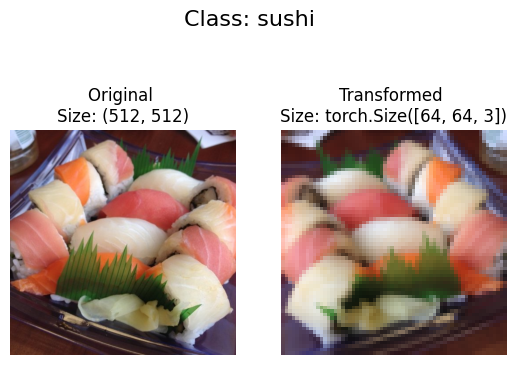

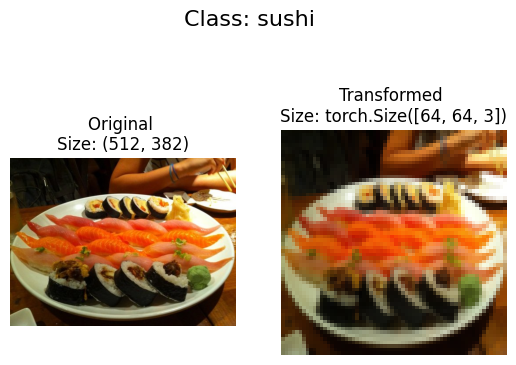

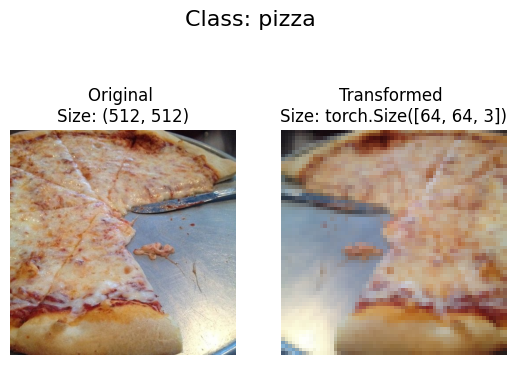

In [ ]:
# Write a function to try those transforms on various images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading Image Data Using ImageFolder

Turn data into a Dataset. Our data is already in standard image classification format: we can use the class torchvision.datasets.ImageFolder.



In [ ]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of image
                                  transform=data_transform, # composition of transforms
                                  target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Looks like PyTorch has registered our Datasets.
Let's inspect them by checking out the classes and class_to_idx attributes as well as the lengths of our training and test sets.

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Plot a single image tensor using matplotlib.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


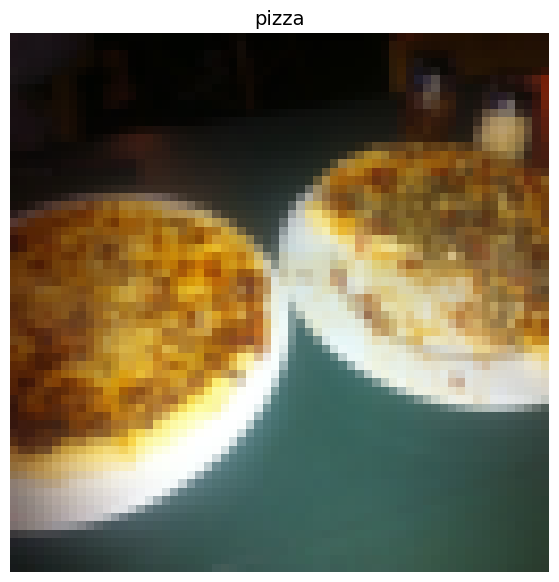

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into DataLoaders

To keep things simple, we'll use a batch_size=1 and num_workers=1.

num_workers: Defines how many subprocesses will be created to load your data, the higher value num_workers is set to, the more compute power PyTorch will use to load your data.

Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes.

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e996b19af80>,
 <torch.utils.data.dataloader.DataLoader at 0x7e996b199360>)

Now our data is iterable.

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

What if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own (doesnt mean it will work, more code but not limited to PyTorch pre built and can create a dataset out of almost anything).

Let's work towards replicating torchvision.datasets.ImageFolder() by subclassing torch.utils.data.Dataset

In [ ]:
import os # for dealing with directories (our data is stored in directories)
import pathlib # dealing with filepaths (each of our image has a unique filepath)
import torch

from PIL import Image # image class for loading images
from torch.utils.data import Dataset # to subclass and create our own custom Dataset
from torchvision import transforms # to turn our images into tensors
from typing import Tuple, Dict, List



Remember how our instances of torchvision.datasets.ImageFolder() allowed us to use the classes and class_to_idx attributes?

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using os.scandir() to traverse a target directory
2. Raise an error if class names not found
3. Turn class names into a dictionary of numerical labels

In [ ]:
# Step 1 (small example)

# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory:
# os.scandir used to get an iterator of os.DirEntry objects corresponding to the entries in the directory given by the specified path
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the class folder names in a target directory.
  Assumes target directory is in standard image classification format.
  Args:
        directory (str): target directory to load classnames from.

  Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

  Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
  """
  # 1. Get the class names by scanning the target diretory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir()) # is_dir checks whether the specified path is a directory or not

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.") # raise keyword is used to raise an exception

  # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

1. Subclass torch.utils.data.Dataset.
2. Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
3. Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).
4. Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
5. Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
6. Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [ ]:
# Write a ustom dataset class (inherists from torch.utils.data.Datase)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize with a targ_dir and transform(optional) parameter
  def __init__(self, targ_dir: str, transform=None) -> None:

    # 3. Create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir) # use function we coded above

  # 4. Make function to load images
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len__() method (optional but recommended)
  def __len__(self) -> int:
    "Returns the total number of samples" # self.paths = all images paths
    return len(self.paths)

  # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor]:
    "Returns one sample of data, data and label (X,y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name #expects path in data_folder/class_name/image.jpe
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return data, label (X, y )



Before we test out our new ImageFolderCustom class, let's create some transforms to prepare our images.

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Let's turn our training images (contained in train_dir) and our testing images (contained in test_dir) into Dataset's using our own ImageFolderCustom class.

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7e996b198220>,
 <__main__.ImageFolderCustom at 0x7e996b19b160>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

1. Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.
2. To prevent the display getting out of hand, we'll cap n at 10 images.
3. Set the random seed for reproducible plots (if seed is set).
4. Get a list of random sample indexes (we can use Python's random.sample() for this) to plot.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes found in step 4 and plot them with matplotlib.
7. Make sure the sample images are of shape HWC (height, width, color channels) so we can plot them.

In [ ]:
# 1. Takes in Dataset + list of class names
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n) # random.sample chooses k unique random elements from a population sequence or set.

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust image tensor shape for plotting : [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)



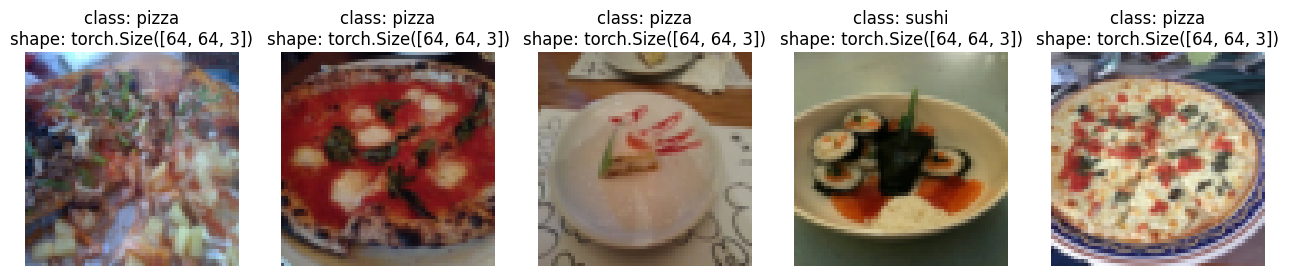

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


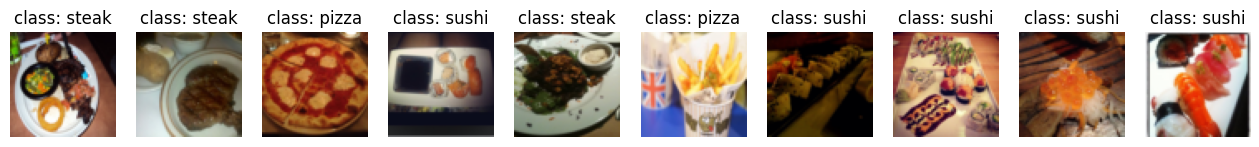

In [ ]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into DataLoader's

Because our custom Dataset's subclass torch.utils.data.Dataset, we can use them directly with torch.utils.data.DataLoader().

And we can do using very similar steps to before except this time we'll be using our custom created Dataset's.

In [ ]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more),Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes.
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e996a537c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7e996a535120>)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom)) # next creates an iterator, and print the items one by one

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

The purpose of tranforms is to alter your images in some way. That may be turning your images into a tensor (as we've seen before). Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as **data augmentation.**

**Data augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

.

ML is all about harnessing the power of randomness and research shows that random transforms generally perform better than hand-picked transforms.

The main parameter to pay attention to in transforms.TrivialAugmentWide() is num_magnitude_bins=31. It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being no range and 31 being maximum range (highest chance for highest intensity).

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

**Note:**

We usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, we do need to make sure your test set images are transformed to tensors. We

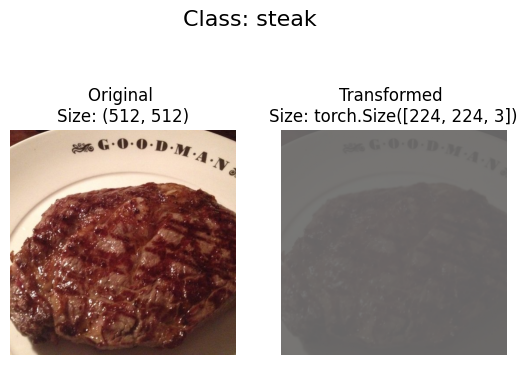

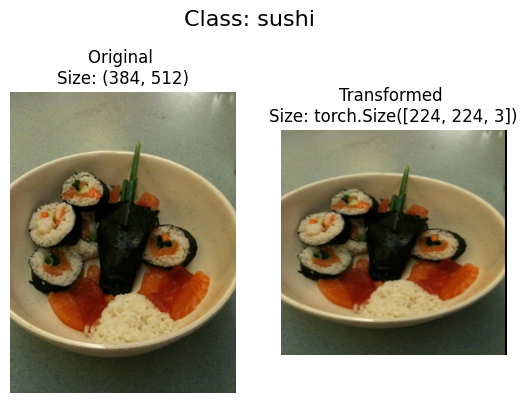

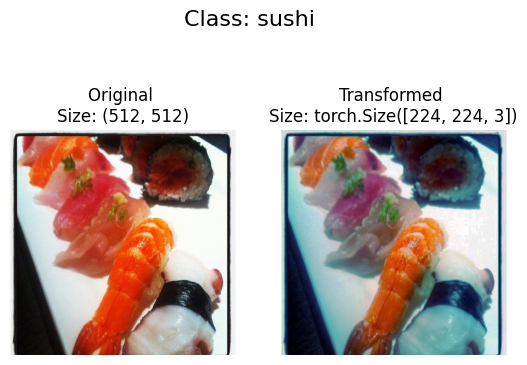

In [ ]:
# Test our data augmentation out!

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images( # Plots a series of random images from image_paths.
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG withouth data augmentation

we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors.

### 7.1 Creating transforms and loading data for Model0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Now we've got a simple transform, let's:

1. Load the data, turning each of our training and test folders first into a Dataset with torchvision.datasets.ImageFolder()
2. Then into a DataLoader using torch.utils.data.DataLoader().
We'll set the batch_size=32 and num_workers to as many CPUs on our machine (this will depend on what machine you're using).

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7e996a2cc970>,
 <torch.utils.data.dataloader.DataLoader at 0x7e996a227970>)

### 7.2 Create TinyVGG model class

In notebook 03, we used the TinyVGG model from the CNN Explainer website.

Let's recreate the same model, except this time we'll be using color images instead of grayscale (in_channels=3 instead of in_channels=1 for RGB pixels).

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

To do a forward pass on a single image:

1. Get a batch of images and labels from the DataLoader.
2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target device).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


### 7.4 Use torchinfo to get an idea of the shapes going through our model

torchinfo comes with a summary() method that takes a PyTorch model as well as an input_shape and returns what happens as a tensor moves through your model.

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions

To make sure we can use these the training and testing loops again, we'll functionize them.
1. train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in train mode
  model.train()

  # Setupt train loss and train accuray valuces
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item() # item: return the dictionary's key-value pairs

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics
    # get the predicted label
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    # how many of the values equal true
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a train() function to combine train_step() and test_step()

Put train_step() and test_step() together. We'll package them up in a train() function.
This function will train the model as well as evaluate it.

To keep track of the number of epochs we've been through, let's import tqdm from tqdm.auto (tqdm is one of the most popular progress bar libraries for Python and tqdm.auto automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc":[]
             }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):

    # calling train_step function
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    # calling test_step function
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # 4. Print out what's happening
    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    # Ensure all data is moved to CPU + converted to float for storage with isinstance function
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and Evaluate Model 0

Time to put our TinyVGG model to see if we can build a model to discern between ppizza steak and sushi. Let's recreate model_0 (we don't need to but we will for completeness) then call our train() function passing in the necessary parameters.


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # 3 for RGB
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple, # dataloader with simple transforms
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1433 | test_acc: 0.1979
Total training time: 6.163 seconds


Model performed really poorly.
How to improve it?

### Plot the loss curves of Model 0

Loss curves show the model's results over time.

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
model_0_results

{'train_loss': [1.1078356355428696,
  1.0846449136734009,
  1.1152610331773758,
  1.099033996462822,
  1.0989171117544174],
 'train_acc': [0.2578125, 0.42578125, 0.29296875, 0.2890625, 0.29296875],
 'test_loss': [1.1362075010935466,
  1.162167986234029,
  1.1694674889246623,
  1.1341702938079834,
  1.1433197259902954],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666]}

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

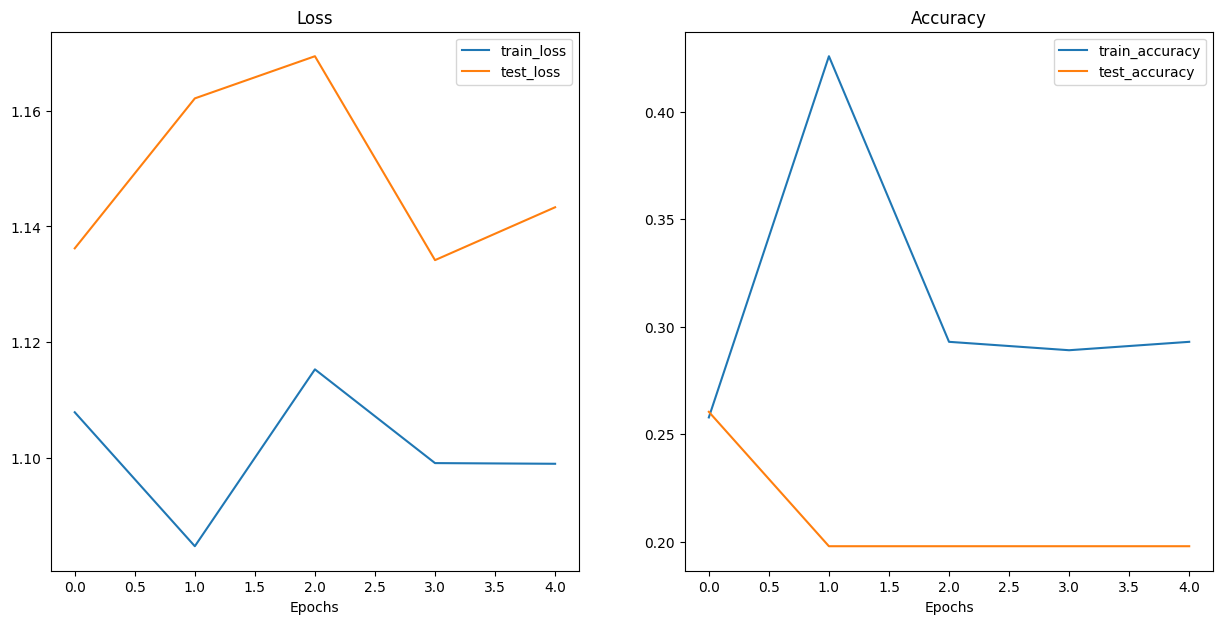

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered underfitting.

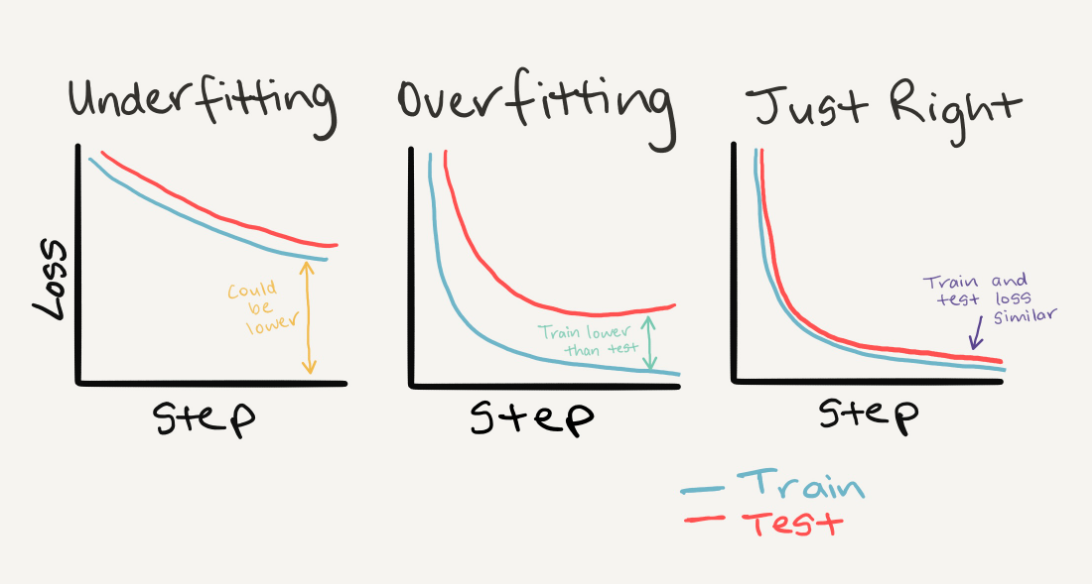

### 8.1 How to deal with overfitting

The model is fitting the trainin data too well, we want to use techniques to "reign it in".

A common technique: **regularization**.
ie: making our model more "regular" to fit more kinds of data.

Method to prevent overfitting:
* Get more data: more opportunities to learn patterns which may be more generalizable to new examples.
* Simplify model: it's learning patterns of the data too well, isn't able to generalize well to unseen data. For example we can reduce number of layers/reduce number of hidden units in each layer.
* Data augmentation: manipulate training data so that's it's harder for the model to learn. Artificilly adds more variety to the data.
* Transfer Learning: TL involves leveraging the patterns (ie pretrained weights) one model has learned to use as the foundation for our own task.  
* Use dropout layers: Randomnly remove connections between hidden layers, simplifying a model.
* Use learning rate decay: slowly decrease the learning rate as a model trains.
The closer you get to convergence the smaller you want your weights updates to be.
* Use early stopping: stops model training before it begins to overfit.  


### 8.2 How to deal with underfitting

When a model is **underfitting** it is considered to have poor predictive power on the training and test sets.
An underfitting model will fail to reduce the loss values to a desired level.

How to increase our model's predictive power?
* Add more layers/units to our model: may not have enough capability to learn the required patterns/weights/representations of the data to be predictive.
* Tweak the learning rate: Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything.
* Transfer learning: Transfer learning is capable of preventing overfitting and underfitting.
* Train for longer: Sometimes a model just needs more time to learn representations of data.
* Use less regularization: Maybe we're trying to prevent overfitting too much. Holding back on regularization techniques can help the model fit the data better.

### 8.3 The balance between overfitting and underfitting

Preventing overfitting and underfitting is possibly the most active area of machine learning research.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours.

## Model 1: TinyVGG with Data Augmentation

Let's load in the data and use data augmentation to see if it improves results.

First, we'll compose a training transform to include transforms.TrivialAugmentWide() as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

### 9.1 Create transform with data augmentation

Here we're using TrivialAugmentWide: https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

The TrivialAugmentWide is an alternate implementation of AutoAugment. However, instead of transforming an image multiple times, it transforms an image only once using a random transform from a given list with a random strength number.

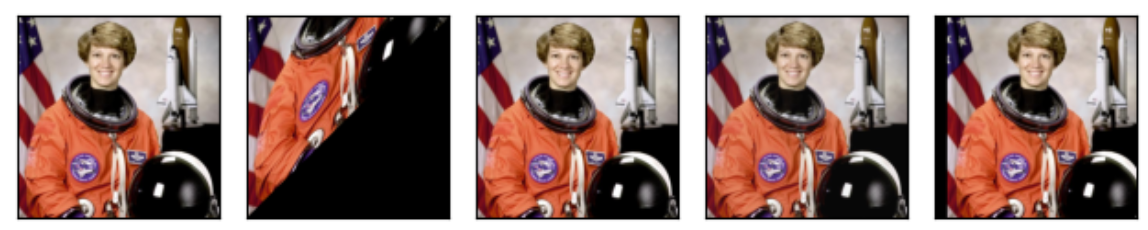

In [ ]:
# Create traning transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Now let's turn our images into Dataset's using torchvision.datasets.ImageFolder() and then into DataLoader's with torchvision.utils.data.DataLoader().

### 9.2 Create train and test Dataset's and DataLoader's

We'll make sure the train Dataset uses the train_transform_trivial_augment and the test Dataset uses the test_transform.

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

And we'll make DataLoader's with a batch_size=32 and with num_workers set to the number of CPUs available on our machine (we can get this using Python's os.cpu_count()).

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)
test_dataloader_augmented = DataLoader(test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)
train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e996b52e830>,
 <torch.utils.data.dataloader.DataLoader at 0x7e996b199360>)

### 9.3 Construct and train Model 1

We can reuse our TinyVGG class from before.

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Since we've already got functions for the training loop (train_step()) and testing loop (test_step()) and a function to put them together in train(), let's reuse those.

We'll use the same setup as model_0 with only the train_dataloader parameter varying:

* Train for 5 epochs.
* Use train_dataloader=train_dataloader_augmented as the training data in train().
* Use torch.nn.CrossEntropyLoss() as the loss function (since we're working with multi-class classification).
* Use torch.optim.Adam() with lr=0.001 as the learning rate as the optimizer.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1388 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1293 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1480 | test_acc: 0.2604
Total training time: 6.999 seconds


Doesn't look like our model performed very well.

### 9.4 Plot the loss curves of Model 1

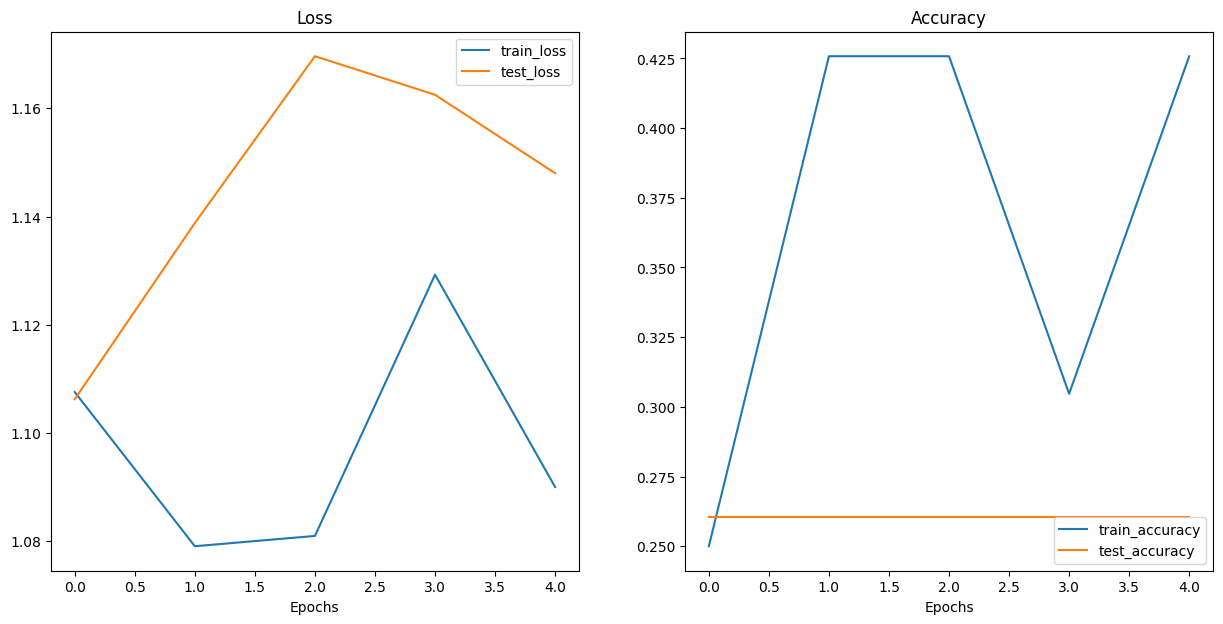

In [ ]:
plot_loss_curves(model_1_results)

Is our model underfitting or overfitting?

Or both?

Ideally we'd like it have higher accuracy and lower loss right?

## 10. Compare model results

Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results into pandas DataFrames.
A Pandas DataFrame is a 2 dimensional data structure, like a 2 dimensional array, or a table with rows and columns.

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.107836   0.257812   1.136208  0.260417
 1    1.084645   0.425781   1.162168  0.197917
 2    1.115261   0.292969   1.169467  0.197917
 3    1.099034   0.289062   1.134170  0.197917
 4    1.098917   0.292969   1.143320  0.197917,
    train_loss  train_acc  test_loss  test_acc
 0    1.107564   0.250000   1.106237  0.260417
 1    1.079069   0.425781   1.138803  0.260417
 2    1.080970   0.425781   1.169633  0.260417
 3    1.129254   0.304688   1.162507  0.260417
 4    1.090012   0.425781   1.148003  0.260417)

Let's visualize the results together.

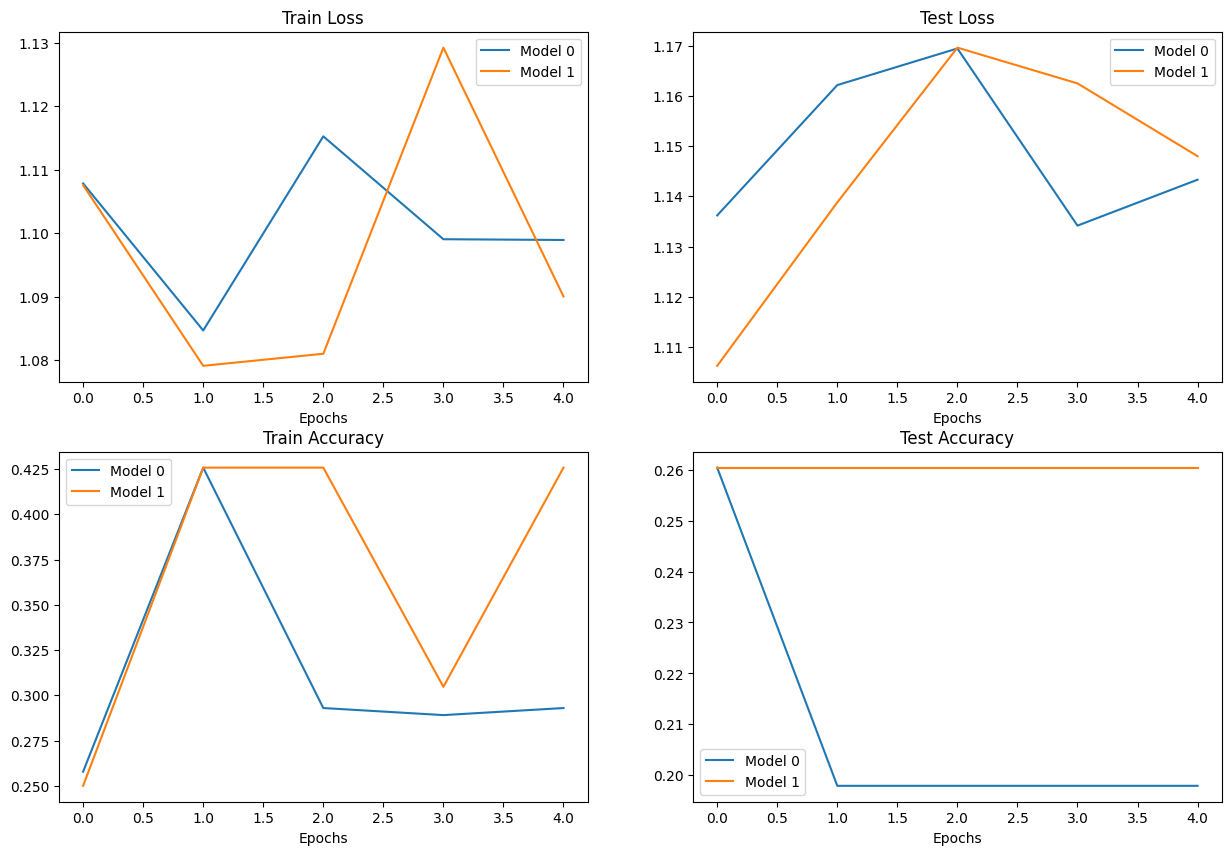

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

It looks like our models both performed equally poorly and were kind of sporadic (the metrics go up and down sharply).

## 11. Make a prediction on a custom image

PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io.

Since we want to load in an image, we'll use torchvision.io.read_image().

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image("/content/7759.jpg")

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[ 38,  40,  40,  ..., 183, 183, 184],
         [ 35,  37,  37,  ..., 185, 185, 187],
         [ 34,  35,  35,  ..., 186, 188, 190],
         ...,
         [ 41,  42,  61,  ..., 206, 206, 207],
         [ 48,  50,  48,  ..., 207, 208, 207],
         [ 61,  78,  70,  ..., 208, 209, 209]],

        [[ 43,  45,  45,  ..., 179, 174, 173],
         [ 40,  42,  42,  ..., 181, 176, 176],
         [ 39,  40,  40,  ..., 182, 180, 179],
         ...,
         [ 54,  55,  74,  ..., 212, 212, 213],
         [ 61,  63,  60,  ..., 213, 214, 215],
         [ 74,  91,  82,  ..., 214, 215, 217]],

        [[ 62,  64,  64,  ..., 196, 191, 189],
         [ 59,  61,  61,  ..., 198, 193, 192],
         [ 58,  59,  59,  ..., 199, 195, 193],
         ...,
         [ 98,  99, 119,  ..., 248, 248, 249],
         [106, 108, 108,  ..., 249, 250, 252],
         [119, 136, 130,  ..., 250, 251, 254]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 400, 535])

Custom image dtype

Is this image format compatible with our model?
Our custom_image tensor is of datatype torch.uint8 and its values are between [0, 255].

But our model takes image tensors of datatype torch.float32 and with values between [0, 1].

So before we use our custom image with our model, we'll need to convert it to the same format as the data our model is trained on.

In [ ]:
# Try to make prediction on image in uint8 format (this will fail)
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same


If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

Let's fix this by converting our custom image to the same datatype as what our model was trained on (torch.float32).

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str("/content/7759.jpg"))

# Divide the image pixel values by 255 to get them between 0 and 1
custom_image = custom_image / 255

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1490, 0.1569, 0.1569,  ..., 0.7176, 0.7176, 0.7216],
         [0.1373, 0.1451, 0.1451,  ..., 0.7255, 0.7255, 0.7333],
         [0.1333, 0.1373, 0.1373,  ..., 0.7294, 0.7373, 0.7451],
         ...,
         [0.1608, 0.1647, 0.2392,  ..., 0.8078, 0.8078, 0.8118],
         [0.1882, 0.1961, 0.1882,  ..., 0.8118, 0.8157, 0.8118],
         [0.2392, 0.3059, 0.2745,  ..., 0.8157, 0.8196, 0.8196]],

        [[0.1686, 0.1765, 0.1765,  ..., 0.7020, 0.6824, 0.6784],
         [0.1569, 0.1647, 0.1647,  ..., 0.7098, 0.6902, 0.6902],
         [0.1529, 0.1569, 0.1569,  ..., 0.7137, 0.7059, 0.7020],
         ...,
         [0.2118, 0.2157, 0.2902,  ..., 0.8314, 0.8314, 0.8353],
         [0.2392, 0.2471, 0.2353,  ..., 0.8353, 0.8392, 0.8431],
         [0.2902, 0.3569, 0.3216,  ..., 0.8392, 0.8431, 0.8510]],

        [[0.2431, 0.2510, 0.2510,  ..., 0.7686, 0.7490, 0.7412],
         [0.2314, 0.2392, 0.2392,  ..., 0.7765, 0.7569, 0.7529],
         [0.2275, 0.2314, 0.2314,  ..

### 11.2 Predicting on custom images with a trained PyTorch model

It looks like our image data is now in the same format our model was trained on.
Except for one thing...

It's shape.


11.2 Predicting on custom images with a trained PyTorch model
Beautiful, it looks like our image data is now in the same format our model was trained on.

Except for one thing...

It's shape.

Our model was trained on images with shape [3, 64, 64], whereas our custom image is currently [3, 400, 535].

Are there any torchvision.transforms that could help?

Before we answer that question, let's plot the image with matplotlib to make sure it looks okay, remember we'll have to permute the dimensions from CHW to HWC to suit matplotlib's requirements.

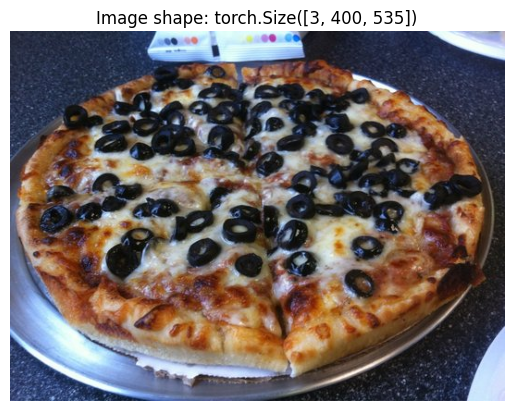

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 400, 535])
New shape: torch.Size([3, 64, 64])


Now let's try to make a prediction.

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

Despite our preparations our custom image and model are on different devices.

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

It looks like we're getting a shape error.
We converted our custom image to be the same size as the images our model was trained on.

There's one dimension we forgot about: batch size.

Our model expects image tensors with a batch size dimension at the start (NCHW where N is the batch size).

We can add a batch size dimension using torch.unsqueeze(dim=0) to add an extra dimension our image and finally make a prediction.

In [ ]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [ ]:
custom_image_pred
# These are still in logit form (the raw outputs of a model are called logits).

tensor([[ 0.1190,  0.0349, -0.1467]], device='cuda:0')

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilites
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probs: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1190,  0.0349, -0.1467]], device='cuda:0')
Prediction probs: tensor([[0.3723, 0.3423, 0.2854]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

It looks like the model gets the prediction right, even though it was performing poorly based on our evaluation metrics.

But if we check the custom_image_pred_probs, we'll notice that the model gives almost equal weight (the values are similar) to every class.

In [ ]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3723, 0.3423, 0.2854]], device='cuda:0')

Having prediction probabilities this similar could mean a couple of things:

The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

### 11.3 Putting custom image prediction together: building a function

Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:

* Takes in a target image path and converts to the right datatype for our model (torch.float32).
* Makes sure the target image pixel values are in the range [0, 1].
* Transforms the target image if necessary.
* Makes sure the model is on the target device.
* Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
* Converts the model's output logits to prediction probabilities.
* Converts the prediction probabilities to prediction labels.
* Plots the target image alongside the model prediction and prediction probability.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

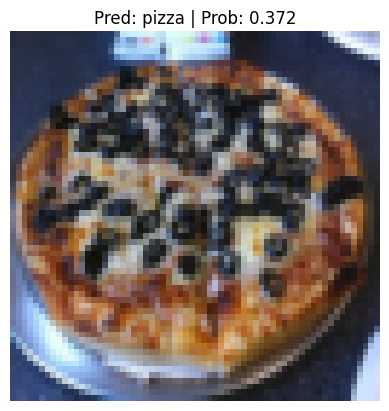

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path="/content/7759.jpg",
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)